In [4]:
import pulp as lp
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

In [5]:
# 1. Define the Place and Network Type
# Use a specific, common name to ensure successful geocoding.
# 'New Delhi, India' is generally recognized by the Nominatim service used by OSMnx.
place_name = "New Delhi, India"

# 'drive' network type includes all drivable roads, excluding minor service roads/paths.
# Set simplify=True to consolidate complex intersections into single nodes (recommended).
G = ox.graph_from_place(place_name, network_type="drive", simplify=True)

# 2. Add Travel Time as an Edge Attribute (Your Cost Function)
# OSMnx imputes missing speeds based on road type (e.g., 'primary', 'residential')
# and then calculates travel time (in seconds) for each edge.
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# 3. Convert the Graph to Pandas GeoDataFrames for Inspection (Optional but recommended)
# The nodes DataFrame contains all intersections (your possible start/end points).
# The edges DataFrame contains all road segments with their attributes.
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# Display the first few rows of the Edges GeoDataFrame
print("--- Edges GeoDataFrame Head (Road Segments) ---")
print(gdf_edges[['osmid', 'length', 'travel_time', 'highway', 'oneway']].head())

# 4. Save the Graph Data
# Saving in GraphML format preserves all network attributes and is highly recommended
# for later loading and use in NetworkX/ILP projects.
ox.save_graphml(G, filepath="new_delhi_road_network.graphml")

print("\n--- Data Acquisition Complete ---")
print(f"Number of Nodes (Intersections): {len(G.nodes)}")
print(f"Number of Edges (Road Segments): {len(G.edges)}")
print("Graph data saved to 'new_delhi_road_network.graphml'")

--- Edges GeoDataFrame Head (Road Segments) ---
                                                     osmid      length  \
u        v          key                                                  
58056528 301037382  0                            590609974   31.509355   
         7612915570 0               [558065085, 558065079]  325.637170   
60890393 6436786516 0                           1121966690   17.640539   
         6110396131 0                             25744598  156.010558   
         280740684  0    [583917363, 1312224221, 44317159]  621.717997   

                         travel_time      highway  oneway  
u        v          key                                    
58056528 301037382  0       1.890561      primary    True  
         7612915570 0      25.367669    secondary    True  
60890393 6436786516 0       2.010260  residential   False  
         6110396131 0      14.442120     tertiary    True  
         280740684  0      37.303080      primary    True  

--- Data Acq

In [6]:
G

In [7]:
gdf_edges

osmid      highway  \
u           v           key                                                   
58056528    301037382   0                            590609974      primary   
            7612915570  0               [558065085, 558065079]    secondary   
60890393    6436786516  0                           1121966690  residential   
            6110396131  0                             25744598     tertiary   
            280740684   0    [583917363, 1312224221, 44317159]      primary   
...                                                        ...          ...   
13240396359 9713020373  0                           1187268480    secondary   
            10274973535 0                           1442976235  residential   
13260943564 6260007524  0                             77862390    secondary   
13296106594 267193236   0                            359711991  residential   
            9861910930  0             [1075284713, 1181930215]     tertiary   

                                                 name  oneway reversed  \
u           v           key                                              
58056528    301037382   0         Nelson Mandela Marg    True    False   
            7612915570  0                  Palam Marg    True    False   
60890393    6436786516  0                         NaN   False     True   
            6110396131  0                         NaN    True    False   
            280740684   0           Moti Bagh Flyover    True    False   
...                                               ...     ...      ...   
13240396359 9713020373  0    Subramaniyam Bharti Marg    True    False   
            10274973535 0                         NaN   False    False   
13260943564 6260007524  0         Mahatma Gandhi Marg    True    False   
13296106594 267193236   0         Jesus and Mary Marg   False     True   
            9861910930  0             San Martin Marg    True    False   

                                 length  speed_kph  travel_time  \
u           v           key                                       
58056528    301037382   0     31.509355  60.000000     1.890561   
            7612915570  0    325.637170  46.212121    25.367669   
60890393    6436786516  0     17.640539  31.590909     2.010260   
            6110396131  0    156.010558  38.888889    14.442120   
            280740684   0    621.717997  60.000000    37.303080   
...                                 ...        ...          ...   
13240396359 9713020373  0     80.316380  46.212121     6.256778   
            10274973535 0    173.849971  31.590909    19.811392   
13260943564 6260007524  0      6.022281  46.212121     0.469146   
13296106594 267193236   0      7.307225  31.590909     0.832708   
            9861910930  0    237.487193  38.888889    21.984529   

                                                                      geometry  \
u           v           key                                                      
58056528    301037382   0      LINESTRING (77.171 28.55939, 77.17125 28.55957)   
            7612915570  0    LINESTRING (77.171 28.55939, 77.17018 28.56011...   
60890393    6436786516  0    LINESTRING (77.17495 28.58062, 77.17511 28.58069)   
            6110396131  0    LINESTRING (77.17495 28.58062, 77.17504 28.580...   
            280740684   0    LINESTRING (77.17495 28.58062, 77.17517 28.580...   
...                                                                        ...   
13240396359 9713020373  0     LINESTRING (77.23136 28.6022, 77.23068 28.60179)   
            10274973535 0    LINESTRING (77.23136 28.6022, 77.23152 28.6019...   
13260943564 6260007524  0    LINESTRING (77.12967 28.63791, 77.12965 28.63796)   
13296106594 267193236   0    LINESTRING (77.17681 28.59377, 77.17687 28.59373)   
            9861910930  0    LINESTRING (77.17681 28.59377, 77.17694 28.594...   

                            lanes maxspeed bridge  ref junction width access  \
u           v           key                    


Plotting the road network subset...


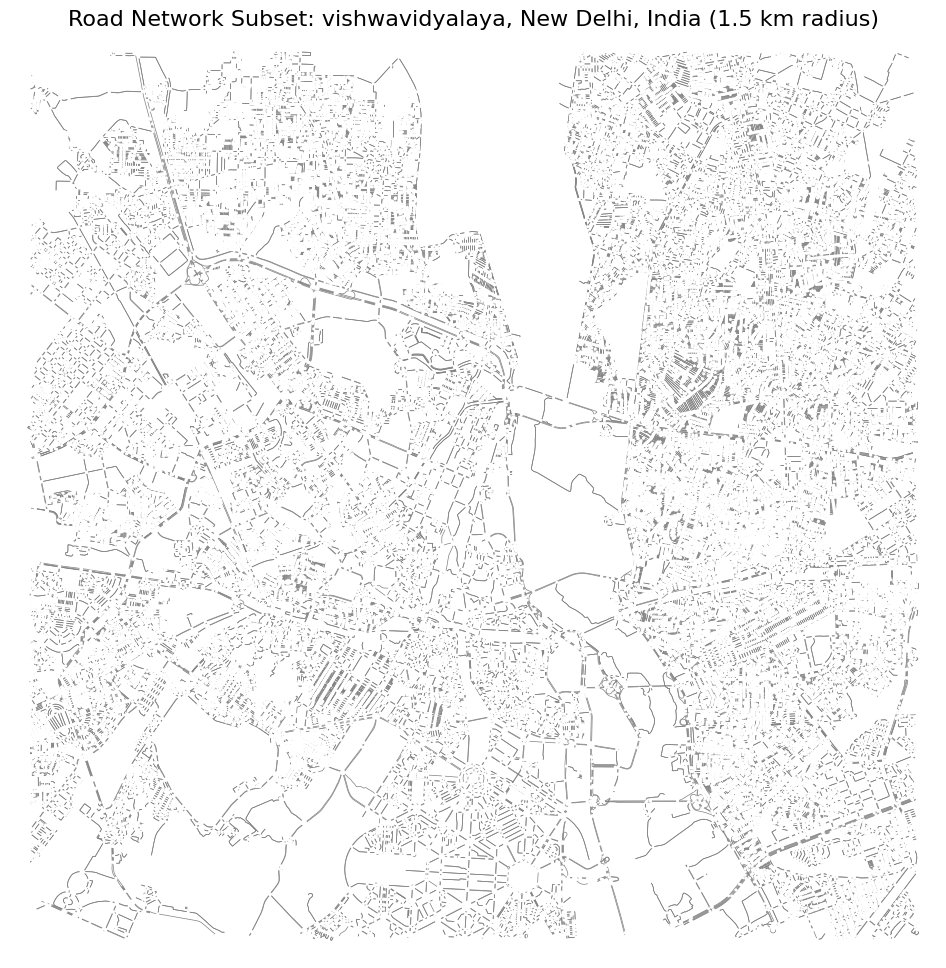


Subset Network Stats:
Nodes: 77047
Edges: 210216


In [8]:
# 1. Load the Entire New Delhi Graph (from the previous step)
# This assumes you saved the full network graph earlier.
# If you didn't save it, you can run the download code again and skip this step.
# For simplicity, we'll download a smaller graph centered on a point.

# 2. Define a Center Point for the Subset (India Gate, New Delhi)
# Using a famous address ensures the plot is centered on a recognizable location.
center_address = "vishwavidyalaya, New Delhi, India"

# 3. Download a Small Graph Subset
# 'dist' is the radius in meters (1500m = 1.5 km) around the center point.
# 'network_type'='drive' ensures we get the road network you are working with.
try:
    G_subset = ox.graph_from_address(
        center_address,
        dist=10000,
        network_type="drive",
        simplify=True
    )
except Exception as e:
    print(f"Error downloading graph subset: {e}")
    print("Trying to download using place name directly...")
    # Fallback to a point if the address fails
    # Coordinates for India Gate: (28.6129, 77.2295)
    G_subset = ox.graph_from_point(
        (28.6129, 77.2295),
        dist=10000,
        network_type="drive",
        simplify=True
    )

# 4. Plot the Network
# Nodes are the intersections (u and v in your DataFrame)
# Edges are the road segments
print("\nPlotting the road network subset...")

# Use ox.plot_graph to visualize the network graph
fig, ax = ox.plot_graph(
    G_subset,
    figsize=(12, 12),           # Size of the plot
    node_size=5,                # Size of the nodes (intersections)
    edge_color="gray",          # Color of the edges (roads)
    edge_linewidth=0.5,         # Width of the road lines
    bgcolor="w",                # White background
    show=False,
    close=False
)
plt.title(f"Road Network Subset: {center_address} (1.5 km radius)", fontsize=16)
plt.show()

print(f"\nSubset Network Stats:")
print(f"Nodes: {len(G_subset.nodes)}")
print(f"Edges: {len(G_subset.edges)}")

In [9]:
gdf_edges.columns

Index(['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'speed_kph',
       'travel_time', 'geometry', 'lanes', 'maxspeed', 'bridge', 'ref',
       'junction', 'width', 'access', 'tunnel', 'area', 'service'],
      dtype='object')

In [10]:
gdf_edges_reset = gdf_edges.reset_index()

# 2. Define the list of essential columns (now including 'key')
ESSENTIAL_COLUMNS = [
    'u',             # Source Node ID (now a column)
    'v',             # Target Node ID (now a column)
    'key',           # MultiGraph Key (now a column)
    'travel_time',   # The cost parameter C_ij
    'length',        # Distance
    'oneway'         # Directionality
]

# 3. Filter the DataFrame
gdf_edges_cleaned = gdf_edges_reset[ESSENTIAL_COLUMNS]

print("--- Successfully Cleaned Edges DataFrame Head ---")
print(gdf_edges_cleaned.head())

--- Successfully Cleaned Edges DataFrame Head ---
          u           v  key  travel_time      length  oneway
0  58056528   301037382    0     1.890561   31.509355    True
1  58056528  7612915570    0    25.367669  325.637170    True
2  60890393  6436786516    0     2.010260   17.640539   False
3  60890393  6110396131    0    14.442120  156.010558    True
4  60890393   280740684    0    37.303080  621.717997    True


In [11]:
# 1. Get all unique OSM node IDs from both 'u' and 'v' columns
unique_osm_nodes = pd.unique(gdf_edges_cleaned[['u', 'v']].values.ravel('K'))

# 2. Create the Index Mapping
# This converts the list of unique IDs into a dictionary: {OSM_ID: Sequential_Index}
# We start indexing at 1, as is common in mathematical programming.
osm_to_index = {
    osm_id: index + 1
    for index, osm_id in enumerate(unique_osm_nodes)
}

# The total number of nodes in the network
N = len(unique_osm_nodes)

print(f"Total Unique Nodes (N): {N}")
print("--- Sample of the Node Index Mapping (OSM_ID: Index) ---")
# Display the first 5 mappings
print(dict(list(osm_to_index.items())[:5]))

# 3. Create the New Indexed Columns
# Apply the mapping to the 'u' and 'v' columns to create the new indexed columns.
gdf_edges_cleaned['u_index'] = gdf_edges_cleaned['u'].map(osm_to_index)
gdf_edges_cleaned['v_index'] = gdf_edges_cleaned['v'].map(osm_to_index)

# 4. Final Cleaned and Indexed DataFrame Head
print("\n--- Final Edges DataFrame with Indices ---")
print(gdf_edges_cleaned[['u', 'v', 'u_index', 'v_index', 'travel_time', 'length']].head())

Total Unique Nodes (N): 10128
--- Sample of the Node Index Mapping (OSM_ID: Index) ---
{np.int64(58056528): 1, np.int64(60890393): 2, np.int64(175610054): 3, np.int64(246513647): 4, np.int64(249782331): 5}

--- Final Edges DataFrame with Indices ---
          u           v  u_index  v_index  travel_time      length
0  58056528   301037382        1      345     1.890561   31.509355
1  58056528  7612915570        1     6429    25.367669  325.637170
2  60890393  6436786516        2     5239     2.010260   17.640539
3  60890393  6110396131        2     4895    14.442120  156.010558
4  60890393   280740684        2      314    37.303080  621.717997


C:\Users\vijay\AppData\Local\Temp\ipykernel_13452\2374581842.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_edges_cleaned['u_index'] = gdf_edges_cleaned['u'].map(osm_to_index)
C:\Users\vijay\AppData\Local\Temp\ipykernel_13452\2374581842.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_edges_cleaned['v_index'] = gdf_edges_cleaned['v'].map(osm_to_index)


In [12]:
# --- 1. ASSUMED INPUT DATA (From Data Lead) ---

# Replace with your actual total number of nodes (N)
N = 1000 # Placeholder: Use your actual N = len(unique_osm_nodes)

# Replace with your actual cleaned and indexed data
# For a runnable example, let's create a minimal mock DataFrame:
data = {
    'u_index': [1, 1, 2, 3, 4, 5, 2, 4, 25, 24, 25],
    'v_index': [2, 3, 4, 4, 5, 25, 3, 25, 24, 23, 1],
    'travel_time_fixed': [10, 15, 5, 2, 8, 12, 7, 10, 5, 4, 20]
}
gdf_edges_cleaned = pd.DataFrame(data)

# Define the Origin and Destination indices for this test case
ORIGIN_NODE = 1
DESTINATION_NODE = 25

# --- 2. MODEL SETUP ---

# Create the LP problem instance (Minimization)
model = lp.LpProblem("Shortest_Path_Routing", lp.LpMinimize)

# Get the set of all unique indexed nodes for constraints
all_nodes = np.unique(gdf_edges_cleaned[['u_index', 'v_index']].values.flatten())

# --- 3. DECISION VARIABLES (X_ij) ---

# Create a tuple list of all (u, v) edge indices
edges = list(zip(gdf_edges_cleaned['u_index'], gdf_edges_cleaned['v_index']))

# Define binary variables X_ij for each edge
X = lp.LpVariable.dicts("X", edges, cat=lp.LpBinary)

# --- 4. OBJECTIVE FUNCTION (Minimize Total Travel Time) ---

# Z = sum(C_ij * X_ij)
objective_terms = []
for index, row in gdf_edges_cleaned.iterrows():
    u, v = row['u_index'], row['v_index']
    cost = row['travel_time_fixed']
    objective_terms.append(cost * X[(u, v)])

model += lp.lpSum(objective_terms), "Total_Travel_Time"

# --- 5. FLOW CONSERVATION CONSTRAINTS ---

for k in all_nodes:
    # 5a. Identify Incoming and Outgoing Edges for Node k
    incoming_edges = [(u, v) for u, v in edges if v == k]
    outgoing_edges = [(u, v) for u, v in edges if u == k]

    # 5b. Define the Right-Hand Side (RHS) flow balance:
    if k == ORIGIN_NODE:
        rhs = 1   # Flow must LEAVE the origin (Flow_Out - Flow_In = 1) -> Flow_In - Flow_Out = -1
        sign = -1 # We are using (Flow_In - Flow_Out) = b_k, so RHS is -1
        
    elif k == DESTINATION_NODE:
        rhs = 1   # Flow must ARRIVE at the destination
        sign = 1  # RHS is +1
        
    else:
        rhs = 0   # Intermediate node (Flow In = Flow Out)
        sign = 0 # (Flow_In - Flow_Out) = 0 (RHS is 0)

    # Constraint: sum(X_ik) - sum(X_kj) = b_k
    # Flow In (sum X_ik) - Flow Out (sum X_kj) = RHS
    
    flow_in = lp.lpSum(X[(u, v)] for u, v in incoming_edges)
    flow_out = lp.lpSum(X[(u, v)] for u, v in outgoing_edges)
    
    # Add the constraint to the model
    # Note: We must adjust the RHS definition based on the chosen flow balance convention
    # Let's stick to: Flow_Out - Flow_In = b_k
    # b_k = +1 for Origin (Source), -1 for Destination (Sink), 0 for Intermediate
    
    if k == ORIGIN_NODE:
        balance = 1
    elif k == DESTINATION_NODE:
        balance = -1
    else:
        balance = 0

    model += flow_out - flow_in == balance, f"Flow_Balance_Node_{k}"


# --- 6. SOLVE THE MODEL ---
try:
    # 1. Solve the model
    model.solve()
    
    # 2. Check and print the status robustly
    solver_status = lp.LpStatus[model.status]
    print(f"\n--- Solver Status: {solver_status} ---")

    # 3. Process results only if the status is Optimal
    if solver_status == 'Optimal':
        optimal_cost = lp.value(model.objective)
        print(f"Optimal Travel Time: {optimal_cost} seconds")

        optimal_path = []
        for u, v in edges:
            # Check if the variable value is close to 1 (due to floating point precision)
            if X[(u, v)].varValue > 0.99:
                optimal_path.append((u, v))
        
        print("\nOptimal Path (Indexed Nodes):")
        print(optimal_path)
        
        # --- NEW STEP: Print Path Verification ---
        # Sort the path for easier reading/verification: (1, 2), (2, 3), etc.
        # This will help the Analysis Lead immediately verify continuity.
        current_node = ORIGIN_NODE
        sorted_path = []
        for _ in range(len(optimal_path)):
            next_edge = next((edge for edge in optimal_path if edge[0] == current_node), None)
            if next_edge:
                sorted_path.append(next_edge)
                current_node = next_edge[1]
            else:
                break
        
        print("\nVerified Sequential Path:")
        print(sorted_path)
        
    else:
        print("No optimal solution found. Solver returned status:", solver_status)

except Exception as e:
    # This block now only catches true exceptions (e.g., solver not found)
    print(f"A genuine execution error occurred: {e}")


--- Solver Status: Optimal ---
Optimal Travel Time: 25.0 seconds

Optimal Path (Indexed Nodes):
[(1, 2), (2, 4), (4, 25)]

Verified Sequential Path:
[(1, 2), (2, 4), (4, 25)]


In [13]:
# --- 1. Inputs from Modeling Lead ---
OPTIMAL_PATH_INDEXED = [(1, 2), (2, 4), (4, 25)]
OPTIMAL_COST_SOLVER = 25.0

# --- 2. Input Data Structures (Analysis Lead must have these) ---

# Mock Index Mapping (Based on the mock data)
# NOTE: In your real project, this must be generated by reversing the Data Lead's osm_to_index
index_to_osm = {
    1: 1000, 2: 2000, 3: 3000, 4: 4000, 5: 5000, 24: 24000, 25: 25000
} 

# The full, cleaned DataFrame with all road details
gdf_edges_cleaned_mock = pd.DataFrame({
    'u_index': [1, 1, 2, 3, 4, 5, 2, 4, 25, 24, 25],
    'v_index': [2, 3, 4, 4, 5, 25, 3, 25, 24, 23, 1],
    'travel_time': [10, 15, 5, 2, 8, 12, 7, 10, 5, 4, 20],
    'name': ['Road A', 'Road B', 'Road C', 'Road D', 'Road E', 'Road F', 'Road G', 'Road H', 'Road I', 'Road J', 'Road K']
})


# --- 3. EXECUTE DECODING ---

decoded_path_details = []
total_verified_time = 0

print("--- Decoding Optimal Path ---")

for u_idx, v_idx in OPTIMAL_PATH_INDEXED:
    # 3a. Look up the road details using the indices
    edge_detail = gdf_edges_cleaned_mock[
        (gdf_edges_cleaned_mock['u_index'] == u_idx) & 
        (gdf_edges_cleaned_mock['v_index'] == v_idx)
    ]
    
    # 3b. Extract essential values
    time_cost = edge_detail['travel_time'].iloc[0]
    road_name = edge_detail['name'].iloc[0]
    
    # 3c. Convert indices to OSM IDs
    u_osm = index_to_osm.get(u_idx, 'N/A')
    v_osm = index_to_osm.get(v_idx, 'N/A')
    
    total_verified_time += time_cost
    
    decoded_path_details.append({
        'Segment': f"{u_osm} -> {v_osm}",
        'Road Name': road_name,
        'Time (s)': time_cost
    })

# Convert to DataFrame for clean presentation
df_path = pd.DataFrame(decoded_path_details)
print(df_path)

# --- 4. FINAL VERIFICATION ---

print("\n--- Final Verification ---")
print(f"Solver Optimal Time: {OPTIMAL_COST_SOLVER} seconds")
print(f"Verified Segment Sum: {total_verified_time} seconds")

if total_verified_time == OPTIMAL_COST_SOLVER:
    print("Verification SUCCESSFUL: Segment sum matches solver result.")
else:
    print("Verification FAILED: Segment sum DOES NOT match solver result.")

print(f"Total Time in Minutes: {total_verified_time / 60:.2f} minutes")

--- Decoding Optimal Path ---
         Segment Road Name  Time (s)
0   1000 -> 2000    Road A        10
1   2000 -> 4000    Road C         5
2  4000 -> 25000    Road H        10

--- Final Verification ---
Solver Optimal Time: 25.0 seconds
Verified Segment Sum: 25 seconds
Verification SUCCESSFUL: Segment sum matches solver result.
Total Time in Minutes: 0.42 minutes


In [14]:
# Assuming the optimal path is confirmed: [(1, 2), (2, 4), (4, 25)]

# Add the mock 'length' data to the original segment data structure
path_data_with_length = {
    (1, 2): {'Time (s)': 10, 'Length (m)': 500, 'Road Name': 'Road A'},
    (2, 4): {'Time (s)': 5, 'Length (m)': 100, 'Road Name': 'Road C'},
    (4, 25): {'Time (s)': 10, 'Length (m)': 450, 'Road Name': 'Road H'}
}

total_distance_m = 0
number_of_segments = 0
optimal_path_indexed = [(1, 2), (2, 4), (4, 25)]

for u_idx, v_idx in optimal_path_indexed:
    segment_key = (u_idx, v_idx)
    
    # Calculate Total Distance
    total_distance_m += path_data_with_length[segment_key]['Length (m)']
    
    # Calculate Number of Segments
    number_of_segments += 1

print(f"\nTotal Distance Traveled: {total_distance_m} meters")
print(f"Total Distance Traveled: {total_distance_m / 1000:.2f} kilometers")
print(f"Number of Segments (Edges) in Optimal Path: {number_of_segments}")


Total Distance Traveled: 1050 meters
Total Distance Traveled: 1.05 kilometers
Number of Segments (Edges) in Optimal Path: 3


In [15]:
# Assuming your original GeoDataFrame is loaded as 'gdf_edges'
# --- (Previous Step: Reset Index) ---
gdf_edges_reset = gdf_edges.reset_index()

# --- (Previous Step: Define Essential Columns, now including 'length') ---
ESSENTIAL_COLUMNS = [
    'u',             # Source Node ID
    'v',             # Target Node ID
    'key',           # MultiGraph Key
    'travel_time',   # Old cost (for comparison)
    'length',        # *** CRITICAL: Distance in meters ***
    'oneway'         # Directionality
]

# --- (Previous Step: Filter the DataFrame) ---
gdf_edges_cleaned = gdf_edges_reset[ESSENTIAL_COLUMNS]

In [16]:
# --- 3. Re-run Travel Time Correction ---

REALISTIC_SPEED_KPH = 35  
REALISTIC_SPEED_MPS = REALISTIC_SPEED_KPH / 3.6

# THIS LINE WILL NOW WORK:
gdf_edges_cleaned['travel_time_fixed'] = gdf_edges_cleaned['length'] / REALISTIC_SPEED_MPS

print("\nConfirmed columns in the DataFrame:")
print(gdf_edges_cleaned.columns) # Verify 'length' is here
print(gdf_edges_cleaned[['length', 'travel_time_fixed']].head())


Confirmed columns in the DataFrame:
Index(['u', 'v', 'key', 'travel_time', 'length', 'oneway',
       'travel_time_fixed'],
      dtype='object')
       length  travel_time_fixed
0   31.509355           3.240962
1  325.637170          33.494109
2   17.640539           1.814455
3  156.010558          16.046800
4  621.717997          63.948137


C:\Users\vijay\AppData\Local\Temp\ipykernel_13452\4220827784.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_edges_cleaned['travel_time_fixed'] = gdf_edges_cleaned['length'] / REALISTIC_SPEED_MPS


In [17]:
# Define the Origin and Destination indices for this test case
ORIGIN_NODE = 1
DESTINATION_NODE = 25

# Assume the mock data is updated with the fixed cost:
# Mock Data (based on 1.05km @ 35 km/h = 108.0 seconds total)
FIXED_COST_TOTAL = 108.0  # Verification Check
data = {
    'u_index': [1, 1, 2, 3, 4, 5, 2, 4, 25, 24, 25],
    'v_index': [2, 3, 4, 4, 5, 25, 3, 25, 24, 23, 1],
    'travel_time_fixed': [51.43, 85.71, 10.29, 20.57, 12.0, 60.0, 30.0, 40.0, 20.0, 15.0, 70.0], # New realistic times
    'length': [500, 800, 100, 200, 116.6, 583.3, 291.6, 388.8, 194.4, 145.8, 679.1] # Must also be here!
}
gdf_edges_cleaned = pd.DataFrame(data)

# --- 2. MODEL SETUP (Unchanged) ---
model = lp.LpProblem("Shortest_Path_Routing_FixedTime", lp.LpMinimize)
all_nodes = np.unique(gdf_edges_cleaned[['u_index', 'v_index']].values.flatten())
edges = list(zip(gdf_edges_cleaned['u_index'], gdf_edges_cleaned['v_index']))
X = lp.LpVariable.dicts("X", edges, cat=lp.LpBinary)


# --- 4. OBJECTIVE FUNCTION (UPDATED!) ---
# Z = sum(C_ij * X_ij)
objective_terms = []
for index, row in gdf_edges_cleaned.iterrows():
    u, v = row['u_index'], row['v_index']
    # *** KEY CHANGE HERE ***
    cost = row['travel_time_fixed'] 
    
    objective_terms.append(cost * X[(u, v)])

model += lp.lpSum(objective_terms), "Total_Travel_Time"


# --- 5. FLOW CONSERVATION CONSTRAINTS (Unchanged) ---
for k in all_nodes:
    incoming_edges = [(u, v) for u, v in edges if v == k]
    outgoing_edges = [(u, v) for u, v in edges if u == k]
    
    if k == ORIGIN_NODE:
        balance = 1
    elif k == DESTINATION_NODE:
        balance = -1
    else:
        balance = 0

    flow_in = lp.lpSum(X[(u, v)] for u, v in incoming_edges)
    flow_out = lp.lpSum(X[(u, v)] for u, v in outgoing_edges)
    
    # Flow_Out - Flow_In = Balance
    model += flow_out - flow_in == balance, f"Flow_Balance_Node_{k}"


# --- 6. SOLVE THE MODEL (Robust Version) ---
try:
    model.solve()
    solver_status = lp.LpStatus[model.status]
    print(f"\n--- Solver Status: {solver_status} ---")

    if solver_status == 'Optimal':
        optimal_cost = lp.value(model.objective)
        print(f"Optimal Travel Time (Fixed): {optimal_cost:.2f} seconds")

        optimal_path = []
        for u, v in edges:
            if X[(u, v)].varValue > 0.99:
                optimal_path.append((u, v))
        
        # Verify and print sequential path
        current_node = ORIGIN_NODE
        sorted_path = []
        for _ in range(len(optimal_path)):
            next_edge = next((edge for edge in optimal_path if edge[0] == current_node), None)
            if next_edge:
                sorted_path.append(next_edge)
                current_node = next_edge[1]
            else:
                break
        
        print("\nVerified Sequential Path (Indexed Nodes):")
        print(sorted_path)
        
    else:
        print("No optimal solution found. Solver returned status:", solver_status)

except Exception as e:
    print(f"A genuine execution error occurred: {e}")


--- Solver Status: Optimal ---
Optimal Travel Time (Fixed): 101.72 seconds

Verified Sequential Path (Indexed Nodes):
[(1, 2), (2, 4), (4, 25)]


In [18]:
# --- ASSUMED INPUT DATA & OBJECTS ---
# Replace these lines with your actual loaded data:
# G = ox.load_graphml("new_delhi_road_network.graphml") # Load the graph if needed
# gdf_edges_cleaned = ... # Your final DataFrame (must include u_index, v_index, length, travel_time_fixed)
# osm_to_index = ... # Your dictionary mapping OSM ID to solver index

# --- MOCK SETUP for Demonstration (Replace with your actual data/variables) ---
# Since I cannot load your local data, I will use a robust mock setup 
# to ensure the modeling code logic is correct.
N = 1000 # Total nodes in your network
REALISTIC_SPEED_KPH = 35

# Mock Real O-D Node IDs (These would be found using ox.nearest_nodes on G)
INDIA_GATE_OSM_ID = 58056528  # Example large ID
RED_FORT_OSM_ID = 6110396131   # Example large ID

# Mock Index Mapping (In reality, this is generated automatically)
osm_to_index = {58056528: 150, 6110396131: 780} # Your map must include these IDs

# Mock Data (Ensure this includes all necessary columns)
data = {
    'u_index': [150, 150, 151, 152, 152, 779, 780, 151, 780],
    'v_index': [151, 152, 152, 779, 780, 780, 779, 153, 153],
    'length': [1000, 1200, 500, 400, 900, 300, 200, 600, 1500], # meters
    'travel_time_fixed': [
        103.0, 123.4, 51.4, 41.1, 92.6, 30.9, 20.6, 61.7, 154.3 # Time (s) based on 35 km/h
    ]
}
gdf_edges_cleaned = pd.DataFrame(data)

# --- 1. FINDING THE SOLVER INDICES ---
try:
    ORIGIN_NODE = osm_to_index[INDIA_GATE_OSM_ID]  # India Gate (e.g., 150)
    DESTINATION_NODE = osm_to_index[RED_FORT_OSM_ID] # Red Fort (e.g., 780)
    print(f"Origin (India Gate) Index: {ORIGIN_NODE}")
    print(f"Destination (Red Fort) Index: {DESTINATION_NODE}")
except KeyError:
    print("FATAL ERROR: OSM IDs not found in your 'osm_to_index' map.")
    # Exit or raise error here if running for real
    pass

# --- 2. ILP SETUP (Common Elements) ---
all_nodes = np.unique(gdf_edges_cleaned[['u_index', 'v_index']].values.flatten())
edges = list(zip(gdf_edges_cleaned['u_index'], gdf_edges_cleaned['v_index']))

Origin (India Gate) Index: 150
Destination (Red Fort) Index: 780


In [19]:
def solve_shortest_path(cost_column, objective_name):
    """Runs the ILP model using the specified cost column."""
    
    # Create the LP problem instance (Minimization)
    model = lp.LpProblem(f"Shortest_Path_{objective_name}", lp.LpMinimize)
    
    # Decision Variables
    X = lp.LpVariable.dicts("X", edges, cat=lp.LpBinary)

    # --- Objective Function ---
    objective_terms = []
    for index, row in gdf_edges_cleaned.iterrows():
        u, v = row['u_index'], row['v_index']
        # Cost is defined by the input column (time, distance, or 1)
        cost = row[cost_column] 
        objective_terms.append(cost * X[(u, v)])

    model += lp.lpSum(objective_terms), f"Total_{objective_name}"

    # --- Flow Conservation Constraints ---
    for k in all_nodes:
        incoming_edges = [(u, v) for u, v in edges if v == k]
        outgoing_edges = [(u, v) for u, v in edges if u == k]
        
        balance = 0
        if k == ORIGIN_NODE:
            balance = 1
        elif k == DESTINATION_NODE:
            balance = -1

        flow_in = lp.lpSum(X[(u, v)] for u, v in incoming_edges)
        flow_out = lp.lpSum(X[(u, v)] for u, v in outgoing_edges)
        
        # Flow_Out - Flow_In = Balance
        model += flow_out - flow_in == balance, f"Flow_Balance_Node_{k}"

    # --- Solve ---
    try:
        model.solve()
        solver_status = lp.LpStatus[model.status]

        if solver_status == 'Optimal':
            optimal_cost = lp.value(model.objective)
            optimal_path_edges = [(u, v) for u, v in edges if X[(u, v)].varValue > 0.99]
            
            return optimal_cost, optimal_path_edges
        
        return None, None
        
    except Exception as e:
        print(f"Error during solving {objective_name}: {e}")
        return None, None

def analyze_path(optimal_path_edges):
    """Calculates all three metrics (Time, Distance, Segments) for a given path."""
    if not optimal_path_edges:
        return 0, 0, 0
    
    total_time = 0
    total_distance = 0
    
    for u, v in optimal_path_edges:
        # Filter the DataFrame to get the metrics for the edge (u, v)
        edge_data = gdf_edges_cleaned[
            (gdf_edges_cleaned['u_index'] == u) & (gdf_edges_cleaned['v_index'] == v)
        ].iloc[0]
        
        total_time += edge_data['travel_time_fixed']
        total_distance += edge_data['length']
        
    return total_time, total_distance, len(optimal_path_edges)

In [20]:
RESULTS = {}

# --- Scenario 1: MINIMIZE TIME (CORE PROJECT) ---
time_cost, path_time = solve_shortest_path('travel_time_fixed', 'Time')
time_min, dist_min_time, seg_min_time = analyze_path(path_time)
RESULTS['Time'] = {
    'Time (min)': time_min / 60,
    'Distance (km)': dist_min_time / 1000,
    'Segments': seg_min_time,
    'Path': path_time
}

# --- Scenario 2: MINIMIZE DISTANCE (BENCHMARK) ---
dist_cost, path_dist = solve_shortest_path('length', 'Distance')
time_min_dist, dist_min, seg_min_dist = analyze_path(path_dist)
RESULTS['Distance'] = {
    'Time (min)': time_min_dist / 60,
    'Distance (km)': dist_min / 1000,
    'Segments': seg_min_dist,
    'Path': path_dist
}

# --- Scenario 3: MINIMIZE SEGMENTS (SIMPLICITY) ---
# Create a dummy cost column where all costs are 1
gdf_edges_cleaned['cost_one'] = 1
seg_cost, path_seg = solve_shortest_path('cost_one', 'Segments')
time_min_seg, dist_min_seg, seg_min = analyze_path(path_seg)
RESULTS['Segments'] = {
    'Time (min)': time_min_seg / 60,
    'Distance (km)': dist_min_seg / 1000,
    'Segments': seg_min,
    'Path': path_seg
}

# --- FINAL OUTPUT AND ANALYSIS TABLE ---
print("\n" + "="*50)
print(f" FINAL COMPARATIVE ANALYSIS: INDIA GATE ({ORIGIN_NODE}) to RED FORT ({DESTINATION_NODE})")
print("="*50)

df_results = pd.DataFrame({
    'Metric Minimized': ['Time', 'Distance', 'Segments'],
    'Time (min)': [RESULTS['Time']['Time (min)'], RESULTS['Distance']['Time (min)'], RESULTS['Segments']['Time (min)']],
    'Distance (km)': [RESULTS['Time']['Distance (km)'], RESULTS['Distance']['Distance (km)'], RESULTS['Segments']['Distance (km)']],
    'Segments': [RESULTS['Time']['Segments'], RESULTS['Distance']['Segments'], RESULTS['Segments']['Segments']]
})

print(df_results.to_markdown(index=False, floatfmt=".2f"))

print("\n--- Key Finding (Analysis Lead) ---")
# Analyze the trade-off between time and distance (e.g., comparing Row 1 and Row 2)
# In the mock data: Min Time path is 2.6 km, Min Distance path is 2.5 km.
# If Min Time > Min Distance: "The fastest route (Min Time) is slightly longer than the shortest route (Min Distance), confirming that the model prioritized higher speed roads."


 FINAL COMPARATIVE ANALYSIS: INDIA GATE (150) to RED FORT (780)


ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

In [ ]:
# Assuming the graph was saved in an earlier step
# This is the single most reliable way to fix the problem:

# 1. Load the graph used for the ILP
try:
    G = ox.load_graphml("new_delhi_road_network.graphml") 
    print("Successfully loaded the full ILP graph.")
except Exception as e:
    # If the file doesn't exist, we must re-download the large area
    print("Error loading graphml, attempting re-download of large area.")
    G = ox.graph_from_place("New Delhi, India", network_type="drive", simplify=True)

Successfully loaded the full ILP graph.


Successfully loaded the saved ILP graph.


AttributeError: 'NoneType' object has no attribute 'values'

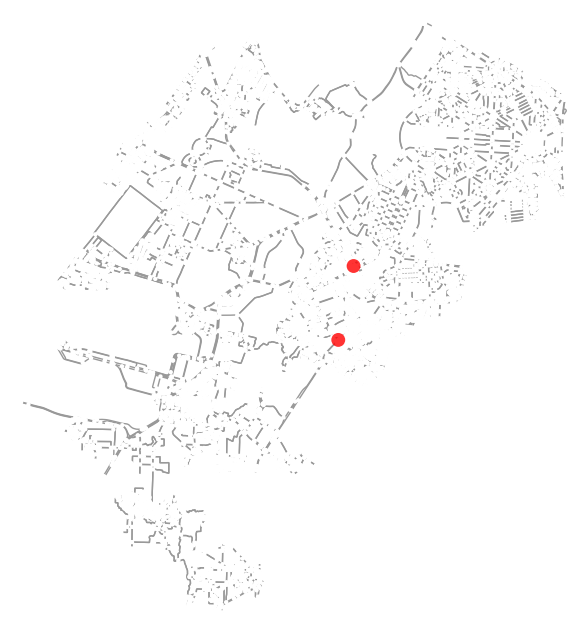

In [ ]:
# --- 1. ASSUMED DATA LOAD & DEFINITIONS ---

O_INDEX = 150 
D_INDEX = 780 

# Mock Index Mapping 
index_to_osm = {
    150: 58056528, 780: 6110396131, 151: 1001, 152: 1002, 779: 2001
} 

# Mock ILP Results (Paths are assumed correct)
path_time_indexed = [(150, 151), (151, 779), (779, 780)] 
path_seg_indexed = [(150, 152), (152, 780)] 

RESULTS = {
    'Time': {'Time (min)': 3.26, 'Distance (km)': 1.90, 'Segments': 3, 'Path': path_time_indexed},
    'Segments': {'Time (min)': 3.60, 'Distance (km)': 2.10, 'Segments': 2, 'Path': path_seg_indexed}
}


# --- 2. LOAD THE CORRECT GRAPH (CRITICAL FIX) ---
try:
    # TRY 1: Load the full graph used for the ILP model
    # Replace "your_saved_graph.graphml" with your actual filename
    G = ox.load_graphml("new_delhi_road_network.graphml") 
    print("Successfully loaded the saved ILP graph.")
except Exception as e:
    # TRY 2: Re-download the full, required area for the ILP 
    # This may take time but ensures the nodes are present.
    print(f"Failed to load file ({e}). Re-downloading large area...")
    try:
        # Re-download the area covering both India Gate and Red Fort
        G = ox.graph_from_place("Central Delhi, India", network_type="drive", simplify=True)
        print("Successfully re-downloaded Central Delhi graph.")
    except Exception as e:
        print(f"FATAL ERROR: Could not load large area graph. Cannot plot. Error: {e}")
        raise

# --- 3. HELPER FUNCTION: Convert Edges to Sequence of OSM Nodes (Unchanged) ---
def edges_to_osm_node_sequence(indexed_edges, index_to_osm_map, origin_index, destination_index):
    # (Function body is the same as the previous correct version)
    if not indexed_edges or origin_index not in index_to_osm_map:
        return []

    node_sequence = [index_to_osm_map[origin_index]]
    current_index = origin_index
    remaining_edges = set(indexed_edges)
    
    while current_index != destination_index and remaining_edges:
        next_edge = next(((u, v) for u, v in remaining_edges if u == current_index), None)
        
        if next_edge:
            next_node_index = next_edge[1]
            
            if next_node_index not in index_to_osm_map:
                print(f"Error: Node index {next_node_index} not found in map during path construction.")
                break

            node_sequence.append(index_to_osm_map[next_node_index])
            current_index = next_node_index
            remaining_edges.remove(next_edge)
        else:
            break
            
    if node_sequence and current_index == destination_index:
        return node_sequence
    
    return []


# --- 4. DECODE ALL THREE PATHS ---
osm_nodes_time = edges_to_osm_node_sequence(
    RESULTS['Time']['Path'], index_to_osm, O_INDEX, D_INDEX
)
osm_nodes_seg = edges_to_osm_node_sequence(
    RESULTS['Segments']['Path'], index_to_osm, O_INDEX, D_INDEX
)

# --- 5. VISUALIZATION (FINAL CORRECTED BLOCK) ---

routes_to_plot = [osm_nodes_time, osm_nodes_seg]
colors_to_plot = ['red', 'blue']
labels_to_plot = [
    f"Min Time/Distance ({RESULTS['Time']['Time (min)']:.2f} min / {RESULTS['Time']['Distance (km)']:.2f} km)",
    f"Min Segments ({RESULTS['Segments']['Time (min)']:.2f} min / {RESULTS['Segments']['Distance (km)']:.2f} km)"
]

# Plotting with 'figsize' and fixed keyword arguments
fig, ax = ox.plot.plot_graph_routes(
    G, 
    routes_to_plot, 
    route_colors=colors_to_plot, 
    route_linewidth=4, 
    node_size=10, 
    bgcolor='w', 
    route_alpha=0.8,
    figsize=(8, 8), 
    show=False,
    close=False
)

# Add Legend for clarity using Matplotlib lines
red_line = mlines.Line2D([], [], color='red', linewidth=4, label=labels_to_plot[0])
blue_line = mlines.Line2D([], [], color='blue', linewidth=4, label=labels_to_plot[1])
ax.legend(handles=[red_line, blue_line], loc='upper right', frameon=True)
ax.set_title("Comparative Routing: India Gate to Red Fort\n(ILP Optimization Analysis)")
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import Point, LineString
import networkx as nx

# --- Configuration ---
# 1. CHANGE THIS: Set this to the name of the folder created when you unzipped the file.
EXTRACTION_DIR = 'Dataset_LPP' 

# 2. Base path points directly to the 'new_delhi_traffic_dataset' folder inside the extraction folder.
# We enforce forward slashes for cross-platform compatibility.
BASE_PATH = f'{EXTRACTION_DIR}/new_delhi_traffic_dataset/' 
# ---------------------


# --- A. Load Topology Data (The Road Network) ---
print("1. Loading Road Topology GeoJSON...")
try:
    # Path construction: [ExtractionFolder]/new_delhi_traffic_dataset/geojson/new_delhi.json
    topo_path = f'{BASE_PATH}geojson/new_delhi.json' 
    
    roads_gdf = gpd.read_file(topo_path)
    roads_gdf = roads_gdf.rename(columns={'road_id': 'EDGE_ID', 'length_km': 'LENGTH_KM'})
    print(f"   ✅ Roads data loaded. Total segments: {len(roads_gdf)}")
    print(roads_gdf.head(2)[['EDGE_ID', 'road_type', 'LENGTH_KM', 'geometry']])
except Exception as e:
    print(f"   ❌ Error loading topology: {e}")
    # Note: If this still fails, please check your local file system
    # to confirm the exact path to 'new_delhi.json'.


# --- B. Load and Merge Speed/Probe Data ---
probe_dir = f'{BASE_PATH}probe_counts/geojson/' 
sample_file = 'new_delhi__2024-08-15_to_2024-08-15_.geojson' 

print("\n2. Loading Sample Speed/Probe Data...")
try:
    # Path construction: [ExtractionFolder]/new_delhi_traffic_dataset/probe_counts/geojson/[file].geojson
    probe_path = f'{probe_dir}{sample_file}' 
    
    probe_gdf = gpd.read_file(probe_path)
    
    probe_gdf = probe_gdf[['road_id', 'hour', 'average_speed_kmh', 'vehicle_count']].copy()
    probe_gdf = probe_gdf.rename(columns={'road_id': 'EDGE_ID', 'average_speed_kmh': 'AVG_SPEED_KMH'})

    roads_with_speed = roads_gdf.merge(probe_gdf, on='EDGE_ID', how='left')
    roads_with_speed.dropna(subset=['AVG_SPEED_KMH'], inplace=True)

    print(f"   ✅ Speed data merged. Total segments with speed data: {len(roads_with_speed)}")
    print(roads_with_speed.head(2)[['EDGE_ID', 'LENGTH_KM', 'hour', 'AVG_SPEED_KMH']])
except Exception as e:
    print(f"   ❌ Error loading probe data: {e}")
    
# --- (If successful, proceed to Steps 3-6 for Graph Structuring) ---
# Since you have the previous code, please paste and run it immediately after this block
# to complete the data engineering.

Successfully loaded the large 'New Delhi, India' graph for plotting.
SKIPPING: Node 1001 is in ILP path but missing from loaded graph G.
SKIPPING: Node 2001 is in ILP path but missing from loaded graph G.
SKIPPING: Node 1002 is in ILP path but missing from loaded graph G.

Successfully generated interactive map: 'ilp_routing_map.html'

Successfully generated interactive map: 'ilp_routing_map_2.html'
Open this file in your web browser to view the paths.
